# Object Detection Demo
## Model preparation
### Variables

In [1]:
from pathlib import Path


# What model to download.
# MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_NAME = "faster_rcnn_inception_v2_coco_2018_01_28"
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = Path("/opt/conda/lib/python3.7/site-packages/tensorflow/models/research").joinpath("object_detection").joinpath("data").joinpath("mscoco_label_map.pbtxt")
PATH_TO_LABELS = Path("__file__").parent.absolute().parent.joinpath("models").joinpath("research").joinpath("object_detection").joinpath("data").joinpath("mscoco_label_map.pbtxt")

### Download Model

In [2]:
import urllib


opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

('faster_rcnn_inception_v2_coco_2018_01_28.tar.gz',
 <http.client.HTTPMessage at 0x173e03026c8>)

### Extract Files

In [3]:
import tarfile


tar_file = tarfile.open(MODEL_FILE)
tar_file.extractall()

### Load a (frozen) Tensorflow model into memory.

In [4]:
import tensorflow


detection_graph = tensorflow.Graph()
with detection_graph.as_default():
    od_graph_def = tensorflow.GraphDef()
    with tensorflow.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, "rb") as g_file:
        serialized_graph = g_file.read()
        print(serialized_graph[:100])
        od_graph_def.ParseFromString(serialized_graph)
        tensorflow.import_graph_def(od_graph_def, name="")

b'\n`\n\x0cimage_tensor\x12\x0bPlaceholder*6\n\x05shape\x12-:+\x12\x0b\x08\xff\xff\xff\xff\xff\xff\xff\xff\xff\x01\x12\x0b\x08\xff\xff\xff\xff\xff\xff\xff\xff\xff\x01\x12\x0b\x08\xff\xff\xff\xff\xff\xff\xff\xff\xff\x01\x12\x02\x08\x03*\x0b\n\x05dtype\x12\x020\x04\n9'


### Loading label map

In [5]:
from object_detection.utils import label_map_util



category_index = label_map_util.create_category_index_from_labelmap(str(PATH_TO_LABELS.absolute()), use_display_name=True)
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

### Detection

In [6]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg

TEST_IMAGE_PATHS = [str(Path("__file__").parent.absolute().parent.joinpath("models").joinpath("research").joinpath("object_detection").joinpath("test_images").joinpath("image1.jpg").absolute()),
                   str(Path("__file__").parent.absolute().parent.joinpath("models").joinpath("research").joinpath("object_detection").joinpath("test_images").joinpath("image2.jpg").absolute())]

print(TEST_IMAGE_PATHS)

['C:\\projects\\Object-detection-try\\models\\research\\object_detection\\test_images\\image1.jpg', 'C:\\projects\\Object-detection-try\\models\\research\\object_detection\\test_images\\image2.jpg']


#### Get handles to input and output tensors

In [7]:
ops = detection_graph.get_operations()
all_tensor_names = {output.name for op in ops for output in op.outputs}
tensor_dict = {}
for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes', 'detection_masks']:
    tensor_name = key + ':0'
    if tensor_name in all_tensor_names:
        tensor_dict[key] = detection_graph.get_tensor_by_name(tensor_name)
tensor_dict

{'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>,
 'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>}

In [8]:
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

#### Helper code

In [9]:
import numpy

from PIL import Image


def load_image_into_numpy_array(image: Image) -> numpy.ndarray:
    (im_width, im_height) = image.size
    return numpy.array(image.getdata()).reshape((im_height, im_width, 3)).astype(numpy.uint8)

In [10]:
load_image_into_numpy_array(Image.open(TEST_IMAGE_PATHS[0]))

array([[[ 53,  39,  26],
        [ 40,  26,  15],
        [ 27,  13,   4],
        ...,
        [233, 221, 199],
        [234, 222, 200],
        [234, 222, 200]],

       [[ 52,  38,  27],
        [ 41,  27,  16],
        [ 31,  17,   8],
        ...,
        [231, 219, 197],
        [231, 219, 197],
        [231, 219, 197]],

       [[ 49,  37,  25],
        [ 43,  29,  20],
        [ 38,  24,  15],
        ...,
        [228, 216, 194],
        [228, 216, 194],
        [228, 216, 194]],

       ...,

       [[ 66,  65,  79],
        [ 64,  63,  77],
        [ 64,  63,  77],
        ...,
        [100, 102, 123],
        [ 92,  96, 121],
        [ 91,  97, 123]],

       [[ 72,  72,  82],
        [ 71,  71,  81],
        [ 68,  68,  78],
        ...,
        [101, 103, 124],
        [ 97, 101, 126],
        [102, 108, 134]],

       [[ 77,  78,  83],
        [ 78,  79,  84],
        [ 75,  76,  81],
        ...,
        [ 98, 100, 123],
        [ 95,  99, 124],
        [101, 107, 133]]

In [11]:
numpy.expand_dims(load_image_into_numpy_array(Image.open(TEST_IMAGE_PATHS[0])), axis=0)

array([[[[ 53,  39,  26],
         [ 40,  26,  15],
         [ 27,  13,   4],
         ...,
         [233, 221, 199],
         [234, 222, 200],
         [234, 222, 200]],

        [[ 52,  38,  27],
         [ 41,  27,  16],
         [ 31,  17,   8],
         ...,
         [231, 219, 197],
         [231, 219, 197],
         [231, 219, 197]],

        [[ 49,  37,  25],
         [ 43,  29,  20],
         [ 38,  24,  15],
         ...,
         [228, 216, 194],
         [228, 216, 194],
         [228, 216, 194]],

        ...,

        [[ 66,  65,  79],
         [ 64,  63,  77],
         [ 64,  63,  77],
         ...,
         [100, 102, 123],
         [ 92,  96, 121],
         [ 91,  97, 123]],

        [[ 72,  72,  82],
         [ 71,  71,  81],
         [ 68,  68,  78],
         ...,
         [101, 103, 124],
         [ 97, 101, 126],
         [102, 108, 134]],

        [[ 77,  78,  83],
         [ 78,  79,  84],
         [ 75,  76,  81],
         ...,
         [ 98, 100, 123],
        

In [12]:
sess = tensorflow.Session(graph=detection_graph)

image = Image.open(TEST_IMAGE_PATHS[0])
# the array based representation of the image will be used later in order to prepare the result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = numpy.expand_dims(image_np, axis=0)
# Run inference
output_dict = sess.run(tensor_dict, feed_dict={image_tensor: image_np_expanded})
    
sess.close()

 # all outputs are float32 numpy arrays, so convert types as appropriate
output_dict['num_detections'] = int(output_dict['num_detections'][0])
output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(numpy.int64)
output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
output_dict['detection_scores'] = output_dict['detection_scores'][0]

output_dict

{'num_detections': 5,
 'detection_boxes': array([[0.05651296, 0.3762494 , 0.960169  , 0.9797817 ],
        [0.02804682, 0.03250726, 0.86715823, 0.31454262],
        [0.        , 0.7006882 , 0.09992104, 0.7956755 ],
        [0.02265929, 0.7847978 , 0.29472438, 0.9639423 ],
        [0.        , 0.27655414, 0.85714245, 0.5556372 ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        

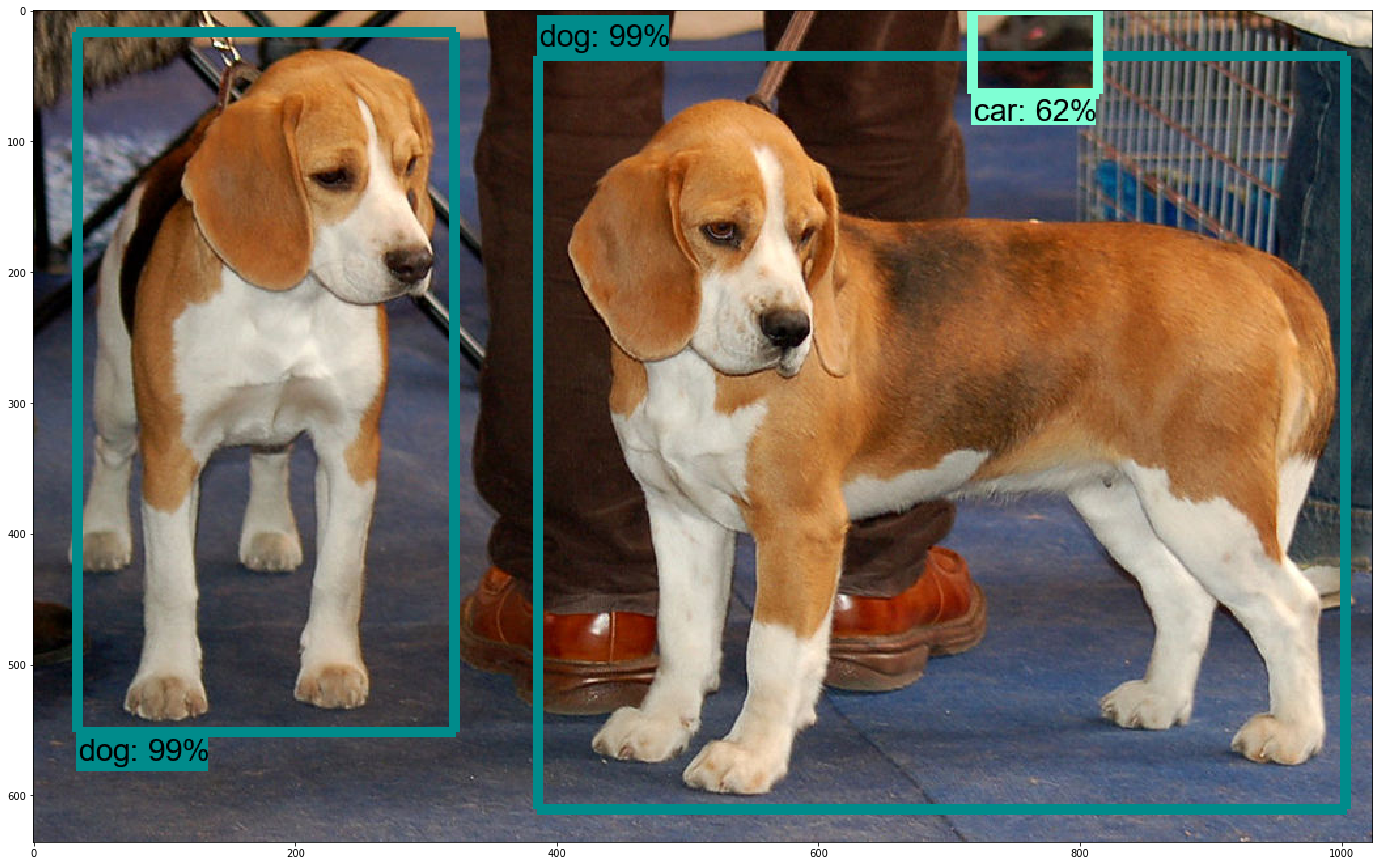

In [13]:
from matplotlib import pyplot
from object_detection.utils import visualization_utils


%matplotlib inline

visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      line_thickness=8)
pyplot.figure(figsize=(24,16))
pyplot.imshow(image_np)
pyplot.show()

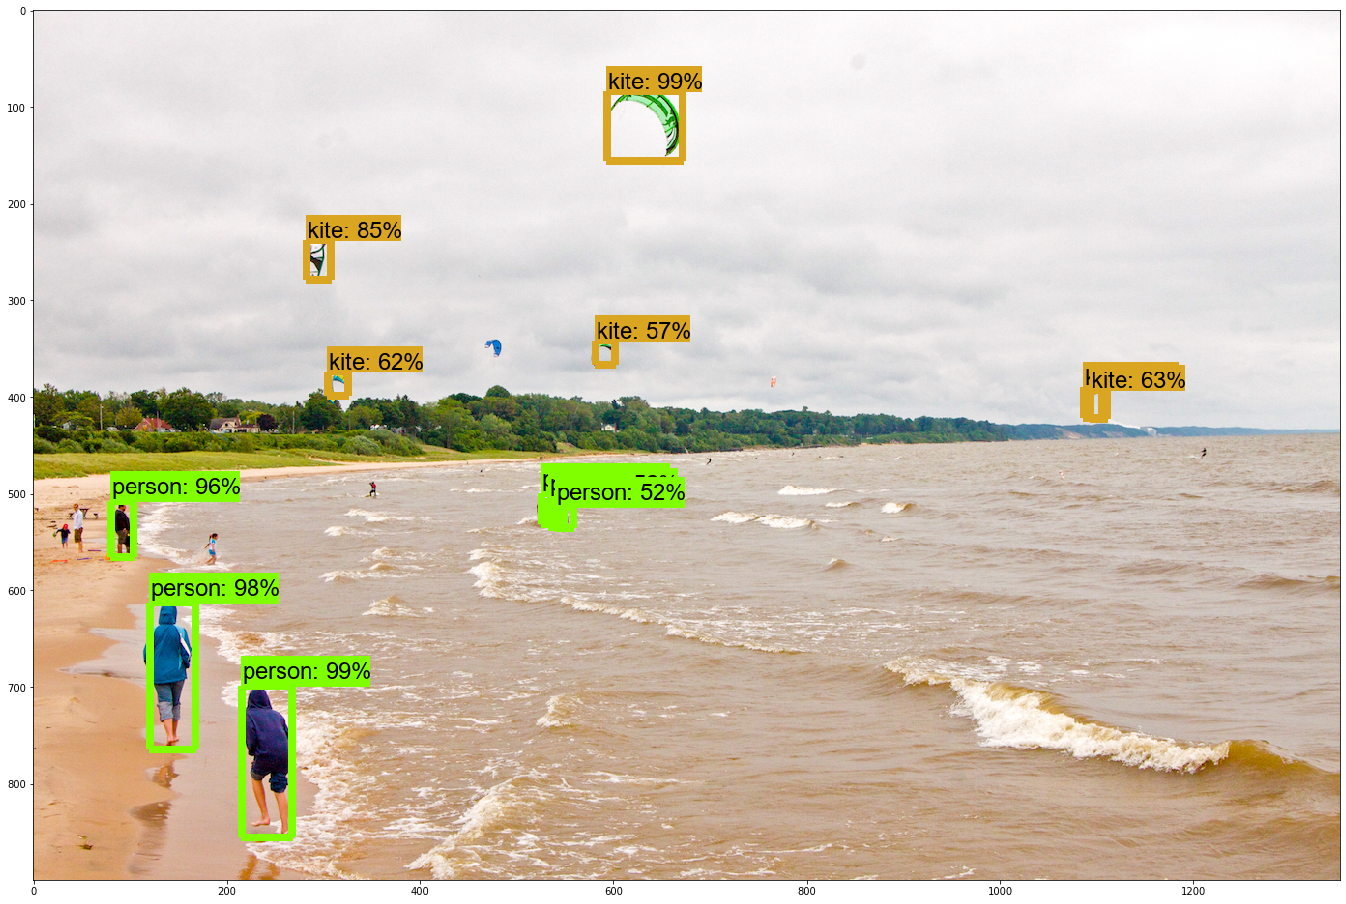

In [14]:
sess = tensorflow.Session(graph=detection_graph)

image = Image.open(TEST_IMAGE_PATHS[1])
# the array based representation of the image will be used later in order to prepare the result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = numpy.expand_dims(image_np, axis=0)
# Run inference
output_dict = sess.run(tensor_dict, feed_dict={image_tensor: image_np_expanded})
    
sess.close()

 # all outputs are float32 numpy arrays, so convert types as appropriate
output_dict['num_detections'] = int(output_dict['num_detections'][0])
output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(numpy.int64)
output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
output_dict['detection_scores'] = output_dict['detection_scores'][0]
visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      line_thickness=8)
pyplot.figure(figsize=(24,16))
pyplot.imshow(image_np)
pyplot.show()